In [25]:
"""
    Ranking:
        1.1 Hierarchical Clustering
"""

'\n    Ranking:\n        1.1 Hierarchical Clustering\n        1.2 Map labels to future matches as home and away\n            1.2.1 If team is new, label it as normal (which is a not promoted team)\n        1.3 Compute difference in ranking\n        1.4 Future work: study the week development of the league to see if there is a point where\n            It can be started to predict the actual behavior of the team as the promotion label\n    Prediction:\n        2.0 Drop features\n        2.1 Features\n            2.1.1 First match as average of past season\n            2.1.2 Average of current season\n            2.1.2.0 All average\n            2.1.2.1 Average at home/away\n            2.1.2.2 Past average of last n games (test with 3, 5, etc)\n            2.1.2.3 Average of last games at home/away\n'

In [1]:
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ranking

In [2]:
# Creates the cophenet matrix array as an numpy matrix
# Not used
def copharray_to_matrix(coph_matrix):
    i = 0
    mat = [np.array([i for i in range(i,19)])]
    suma = 0
    i = 19
    row = []
    while i > 0:
        row = np.array([0 for i in range(i,19)])
        final_row = np.append(row, coph_matrix[suma:suma+i])
        mat = mat + [final_row]
        suma = suma + i
        i = i - 1
    return np.asmatrix(mat)

In [3]:
# This returns the correlation matrix, as well the features correlated over a given trheshold
def get_correlation(data, target, column_names, corr_method, target_name, thresh=0.5):
    df = pd.DataFrame(data, columns=column_names)
    df[target_name] = target
    X = df.drop(target_name,1)   #Feature Matrix
    y = df[target_name] 
    
    #Using Spearman Correlation
    corr = df.corr(method=corr_method)
    
    #Correlation with output variable
    cor_target = abs(corr[target_name])
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>thresh]
    relevant_features = relevant_features.sort_values(ascending=False)
    
    return corr, relevant_features

In [4]:
# Use in the future
def heatmap_data(data, target, column_names, corr_method, target_name):
    #Using Spearman Correlation
    corr, _ = get_correlation(data, target, column_names, corr_method, target_name)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Features vs label")
    plt.show()

In [5]:
# This plots the records correlation against the features, as well 
# the dendogram between the records
def dendogram_vs_features(Z, data, record_names, features_names):
    df = pd.DataFrame(data, index=record_names, columns=features_names)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    g = sns.clustermap(df,
                       figsize=(15, 15),
                       row_linkage=Z,
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(0, .2, .03, .4),
                       center=0,
                       square=True,
                       linewidths=.5,
                       cmap="mako",
                       vmax=.3,
                       cbar_kws={"shrink": .5}).fig.suptitle('Features vs records') 

In [6]:
def dendogram_graph(data, best_method, label):
    label = [l[3:] for l in label]
    Z = linkage(data, best_method)
    coph_matrix = cophenet(Z)
    fig = plt.figure(figsize=(25, 10))
    dendo = dendrogram(Z, leaf_rotation=90, labels=label)
    plt.title(best_method)
    plt.show()
    return (Z, coph_matrix)

def HierarchicalClustering(data, label):
    methods = ["single","complete","average","centroid","ward"]

    # Pass the dataset into pdist to get your proximity matrix for calculating CPCC
    proximity_matrix = pdist(data)

    best_coph = -1
    best_method = None

    for method in methods:
        Z = linkage(data, method)
        coph, coph_matrix = cophenet(Z, proximity_matrix)
        if coph > best_coph:
            best_coph = coph
            best_method = method
            best_matrix = coph_matrix
    final = dendogram_graph(data, best_method, label)
    return final[0], final[1], best_coph

In [7]:
# Returns a list of teams names with its season
def label_team_season(all_names, all_season):
    dendo_label = []
    for i in range(len(all_season)):
        d_l = all_names[i] + " - " + str(all_season[i])
        dendo_label.append(d_l)
    return dendo_label

In [8]:
# Pretty print a np.matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end=" ")
        print("")

In [9]:
""" Returns a dictionary with the clusters in the form
{
    "id": {
        "season" : point -> Attr object
    }
}
"""
def dct_clusters(Z, coph_matrix, dendo_label, criterion='distance'):
    print("threshold = %s" % (coph_matrix[0]))
    matprint(np.around(squareform(coph_matrix),0))
    clusters = fcluster(Z, t=coph_matrix[0], criterion=criterion)
    dct_clusters = dict()
    for i in range(0, len(dendo_label)):
        point = ranking.Attr(dendo_label[i], clusters[i])
        if point.value2 not in dct_clusters:
            dct_clusters[point.value2] = {}
            dct_clusters[point.value2][point.value3] = point
        else:
            dct_clusters[point.value2][point.value3] = point
    return dct_clusters, clusters
    # If needed sort when array
    #h_clusters.sort(key=ranking.get_value)

In [10]:
"""
    RANKING
"""

'\n    RANKING\n'

In [11]:
# League directory
country = 'ES'
league = '140'
curr_week = 38
# Historicity: multi season directory
year_window = 1
start_season = 2019
seasons = list(range(start_season, start_season - year_window, -1))
print(seasons)

[2019]


In [12]:
# Targets
target_col = ["rank", "points", "description"]
# Data initialization
data, column_names = ranking.concat_data(country, league, seasons, target_col, clean_type=None)
initial_data, all_season, all_names, all_target = ranking.get_all_data(data, len(target_col))

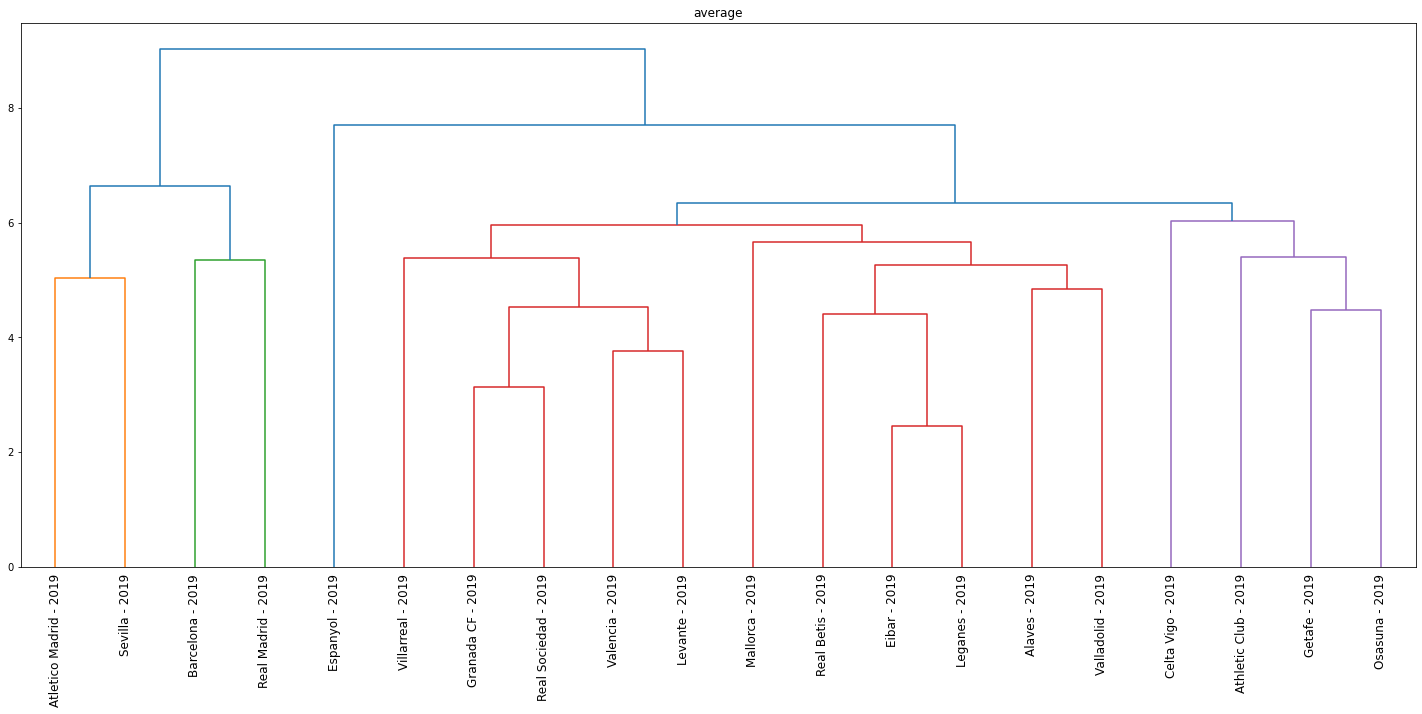

In [13]:
# Use Agglomerative
all_data = preprocessing.StandardScaler().fit_transform(initial_data)
dendo_label = label_team_season(all_names, all_season)
Z, coph_matrix, coph = HierarchicalClustering(all_data, dendo_label)

In [14]:
all_dct, all_lst = dct_clusters(Z, coph_matrix, dendo_label)

threshold = 5.962101047833543
0 6 5 6 5 9 6 6 6 9 5 6 6 9 8 9 6 5 6 6 
6 0 6 6 6 9 6 6 6 9 6 6 6 9 8 9 6 6 6 6 
5 6 0 6 5 9 6 6 6 9 4 6 6 9 8 9 6 5 6 6 
6 6 6 0 6 9 4 5 4 9 6 6 6 9 8 9 6 6 5 6 
5 6 5 6 0 9 6 6 6 9 5 6 6 9 8 9 6 3 6 6 
9 9 9 9 9 0 9 9 9 7 9 9 9 7 9 5 9 9 9 9 
6 6 6 4 6 9 0 5 2 9 6 6 6 9 8 9 6 6 5 6 
6 6 6 5 6 9 5 0 5 9 6 6 6 9 8 9 6 6 5 6 
6 6 6 4 6 9 2 5 0 9 6 6 6 9 8 9 6 6 5 6 
9 9 9 9 9 7 9 9 9 0 9 9 9 5 9 7 9 9 9 9 
5 6 4 6 5 9 6 6 6 9 0 6 6 9 8 9 6 5 6 6 
6 6 6 6 6 9 6 6 6 9 6 0 6 9 8 9 6 6 6 6 
6 6 6 6 6 9 6 6 6 9 6 6 0 9 8 9 5 6 6 5 
9 9 9 9 9 7 9 9 9 5 9 9 9 0 9 7 9 9 9 9 
8 8 8 8 8 9 8 8 8 9 8 8 8 9 0 9 8 8 8 8 
9 9 9 9 9 5 9 9 9 7 9 9 9 7 9 0 9 9 9 9 
6 6 6 6 6 9 6 6 6 9 6 6 5 9 8 9 0 6 6 4 
5 6 5 6 3 9 6 6 6 9 5 6 6 9 8 9 6 0 6 6 
6 6 6 5 6 9 5 5 5 9 6 6 6 9 8 9 6 6 0 6 
6 6 6 6 6 9 6 6 6 9 6 6 5 9 8 9 4 6 6 0 


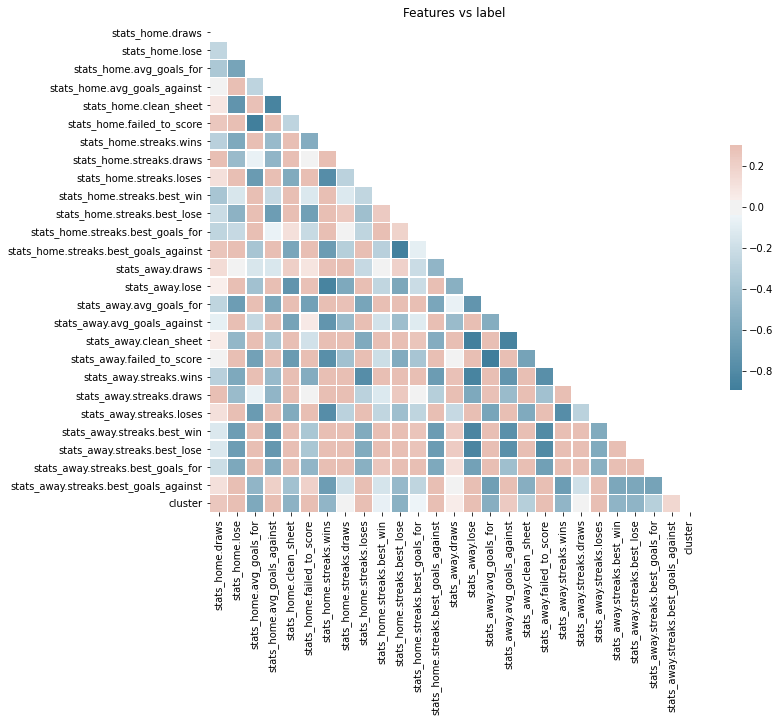

In [15]:
# All_lst is the value of the cluster
# This heatmaps correlate the features against each other, as well the cluster predicted
heatmap_data(all_data, all_lst, column_names, 'spearman', 'cluster')

In [16]:
_, relevant_features = get_correlation(all_data, all_lst, column_names, 'spearman', 'cluster', thresh=0.4)
print(relevant_features)

cluster                                  1.000000
stats_away.streaks.loses                 0.588514
stats_home.streaks.loses                 0.588514
stats_home.avg_goals_against             0.581851
stats_home.avg_goals_for                 0.577255
stats_home.failed_to_score               0.571337
stats_home.lose                          0.565301
stats_away.avg_goals_for                 0.538401
stats_home.streaks.best_lose             0.529091
stats_home.clean_sheet                   0.505929
stats_away.streaks.best_lose             0.496598
stats_away.streaks.best_win              0.496598
stats_away.streaks.wins                  0.487495
stats_home.streaks.wins                  0.487495
stats_away.failed_to_score               0.462083
stats_home.streaks.best_goals_against    0.443889
Name: cluster, dtype: float64


In [69]:
from sklearn.decomposition import PCA
import re

def cluster_scatter(title, data, clusters, label, axes):
    axes.set_title(title)
    pca_data = pd.DataFrame()
    pca = PCA(n_components=2)
    X = pca.fit_transform(data)
    pca_data["PCA1"] = X[:,0]
    pca_data["PCA2"] = X[:,1]
    pca_data["clusters"] = clusters
    label = ["".join(re.findall("[^\W\d_]", x)) for x in label]
    pca_data["names"] = label
    p1 = sns.scatterplot( x='PCA1', y='PCA2', data=pca_data, hue='clusters', style='clusters', legend='full', palette="mako", ax=axes)
    for line in range(0, pca_data.shape[0]):
        p1.text(pca_data['PCA1'][line]+0.01, pca_data['PCA2'][line], 
                 pca_data['names'][line], horizontalalignment='left', size='small', color='black')
    return p1

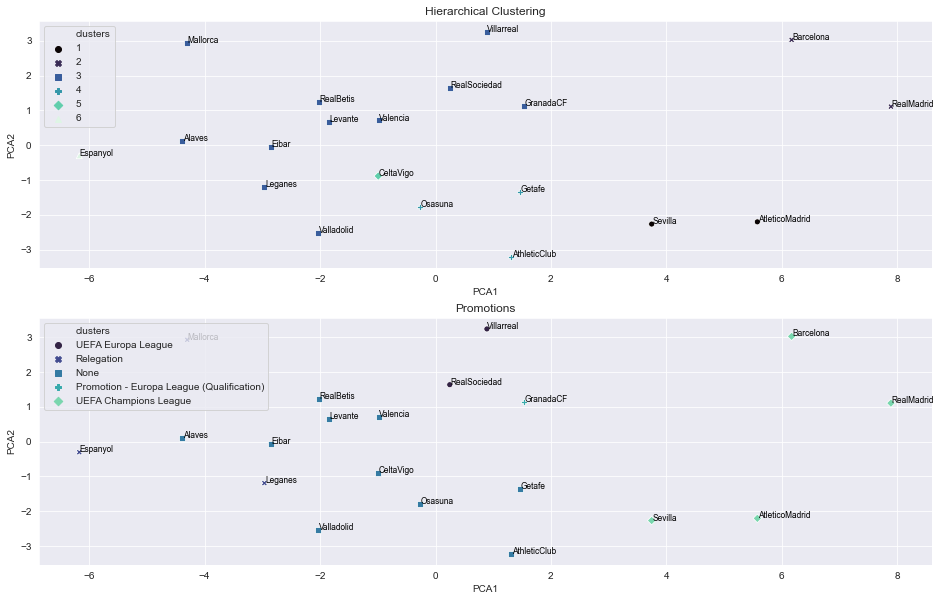

In [72]:
sns.set_style("darkgrid")
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,10))
cluster_scatter('Hierarchical Clustering', all_data, all_lst, dendo_label, ax1)
promotions = [ranking.decode_description(x) for x in all_target[2]]
cluster_scatter('Promotions', all_data, promotions, dendo_label, ax2)

/anaconda3/envs/thesis/lib/python3.7/site-packages/seaborn/matrix.py:1201: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


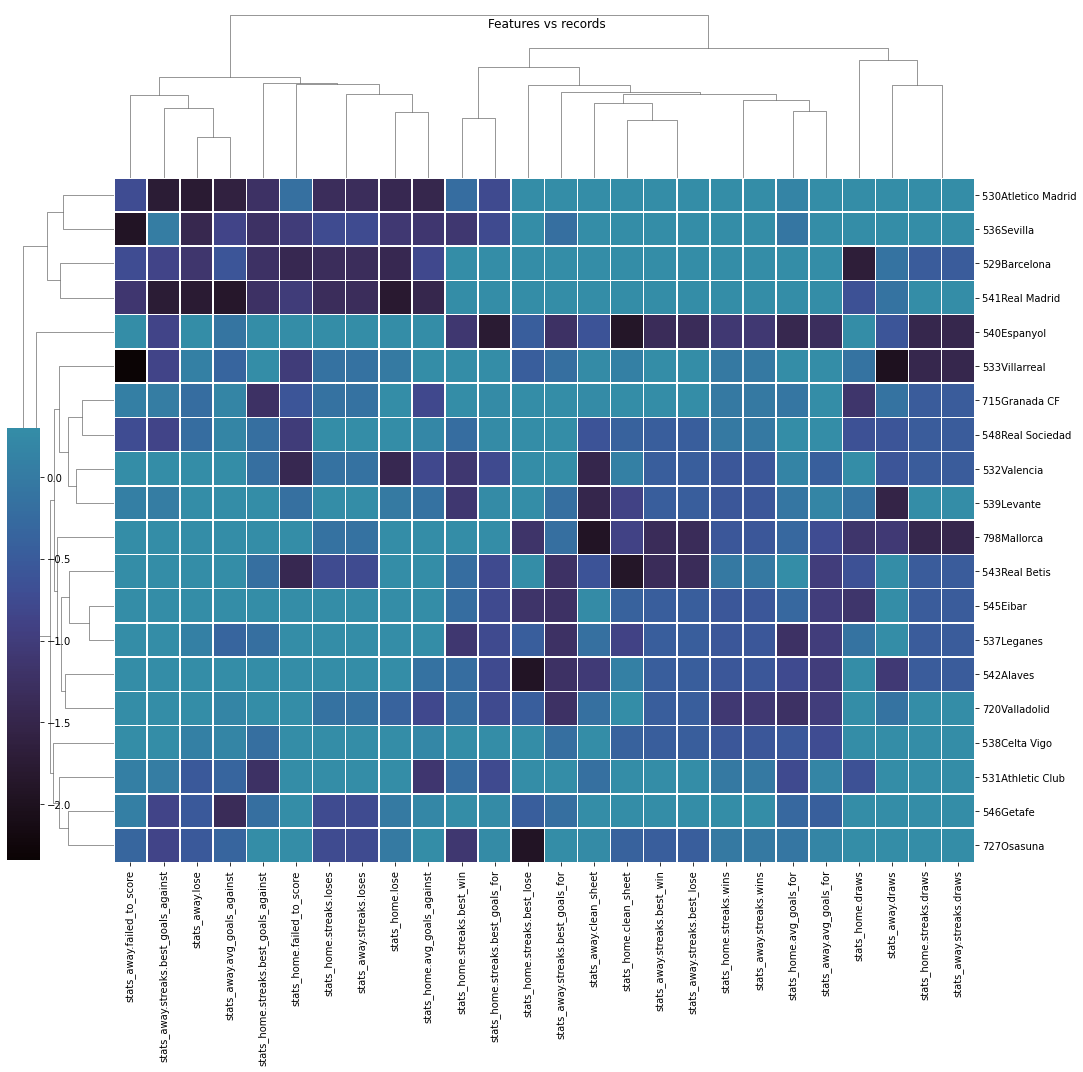

In [17]:
dendogram_vs_features(Z, all_data, all_names, column_names)

In [19]:
# This is the cluster in the team by year
print(all_dct['529']['2019'].value)

2


In [20]:
# Data initialization
data, column_names = ranking.concat_data(country, league, seasons, target_col, clean_type='home')
all_data, all_season, all_names, all_target = ranking.get_all_data(data, len(target_col))

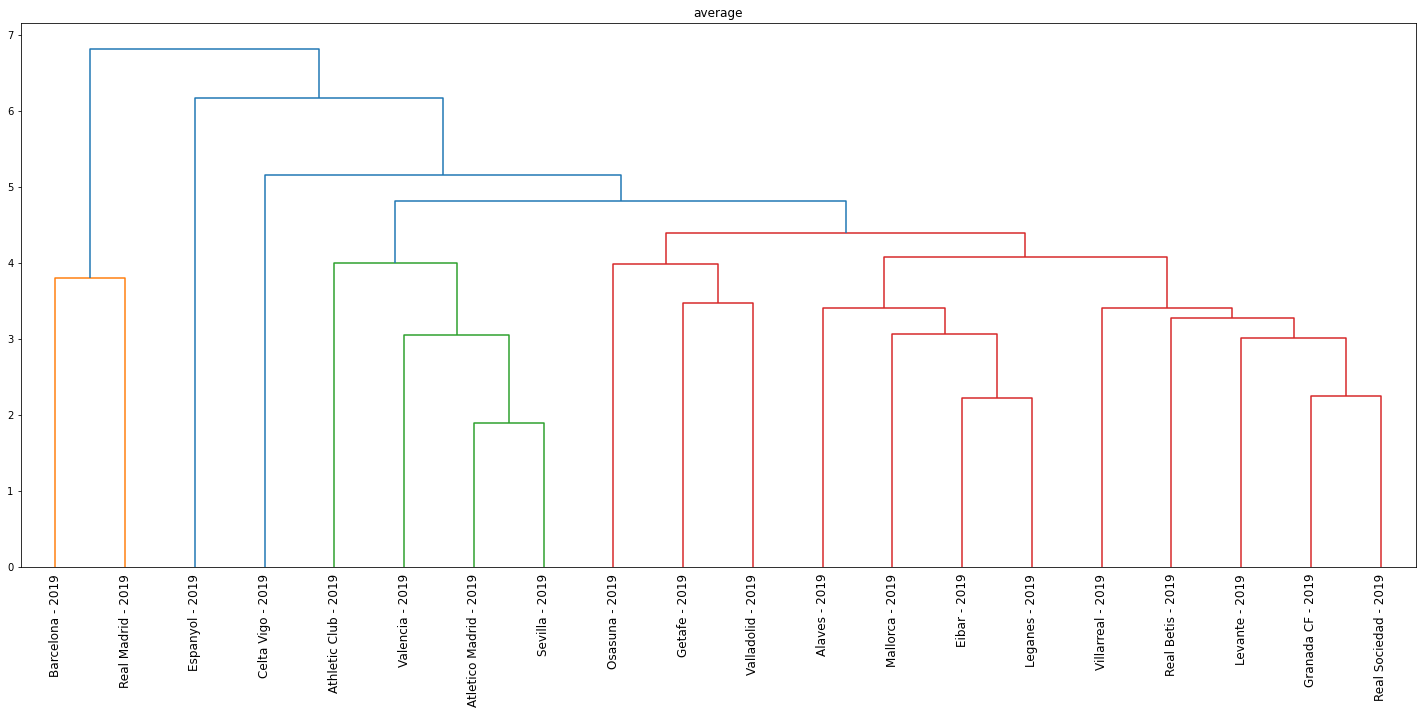

In [21]:
# Use Agglomerative
all_data = preprocessing.StandardScaler().fit_transform(all_data)
dendo_label = label_team_season(all_names, all_season)
Z, coph_matrix, coph = HierarchicalClustering(all_data, dendo_label)

In [22]:
home_dct, _ = dct_clusters(Z, coph_matrix, dendo_label)

threshold = 4.081586676104427
0 4 5 3 3 7 4 4 4 5 3 5 5 5 6 7 4 3 4 4 
4 0 5 4 4 7 3 3 3 5 4 5 5 5 6 7 4 4 4 4 
5 5 0 5 5 7 5 5 5 3 5 5 4 3 6 7 5 5 5 5 
3 4 5 0 3 7 4 4 4 5 3 5 5 5 6 7 4 3 4 4 
3 4 5 3 0 7 4 4 4 5 3 5 5 5 6 7 4 2 4 4 
7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 4 7 7 7 7 
4 3 5 4 4 7 0 3 2 5 4 5 5 5 6 7 4 4 4 4 
4 3 5 4 4 7 3 0 3 5 4 5 5 5 6 7 4 4 4 4 
4 3 5 4 4 7 2 3 0 5 4 5 5 5 6 7 4 4 4 4 
5 5 3 5 5 7 5 5 5 0 5 5 4 2 6 7 5 5 5 5 
3 4 5 3 3 7 4 4 4 5 0 5 5 5 6 7 4 3 4 4 
5 5 5 5 5 7 5 5 5 5 5 0 5 5 6 7 5 5 5 5 
5 5 4 5 5 7 5 5 5 4 5 5 0 4 6 7 5 5 5 5 
5 5 3 5 5 7 5 5 5 2 5 5 4 0 6 7 5 5 5 5 
6 6 6 6 6 7 6 6 6 6 6 6 6 6 0 7 6 6 6 6 
7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 0 7 7 7 7 
4 4 5 4 4 7 4 4 4 5 4 5 5 5 6 7 0 4 3 4 
3 4 5 3 2 7 4 4 4 5 3 5 5 5 6 7 4 0 4 4 
4 4 5 4 4 7 4 4 4 5 4 5 5 5 6 7 3 4 0 4 
4 4 5 4 4 7 4 4 4 5 4 5 5 5 6 7 4 4 4 0 


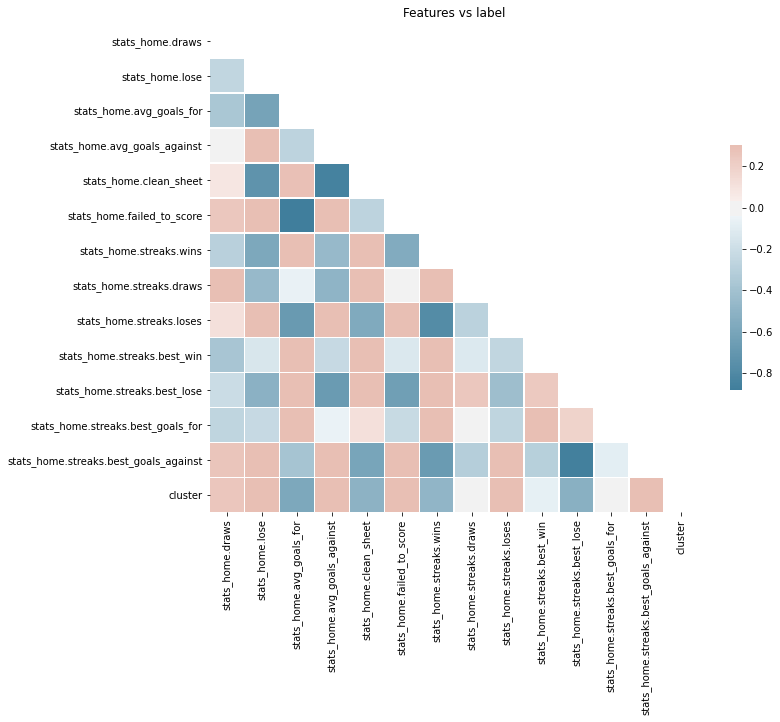

cluster                                  1.000000
stats_home.streaks.loses                 0.588514
stats_home.avg_goals_against             0.581851
stats_home.avg_goals_for                 0.577255
stats_home.failed_to_score               0.571337
stats_home.lose                          0.565301
stats_home.streaks.best_lose             0.529091
stats_home.clean_sheet                   0.505929
stats_home.streaks.wins                  0.487495
stats_home.streaks.best_goals_against    0.443889
Name: cluster, dtype: float64


/anaconda3/envs/thesis/lib/python3.7/site-packages/seaborn/matrix.py:1201: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


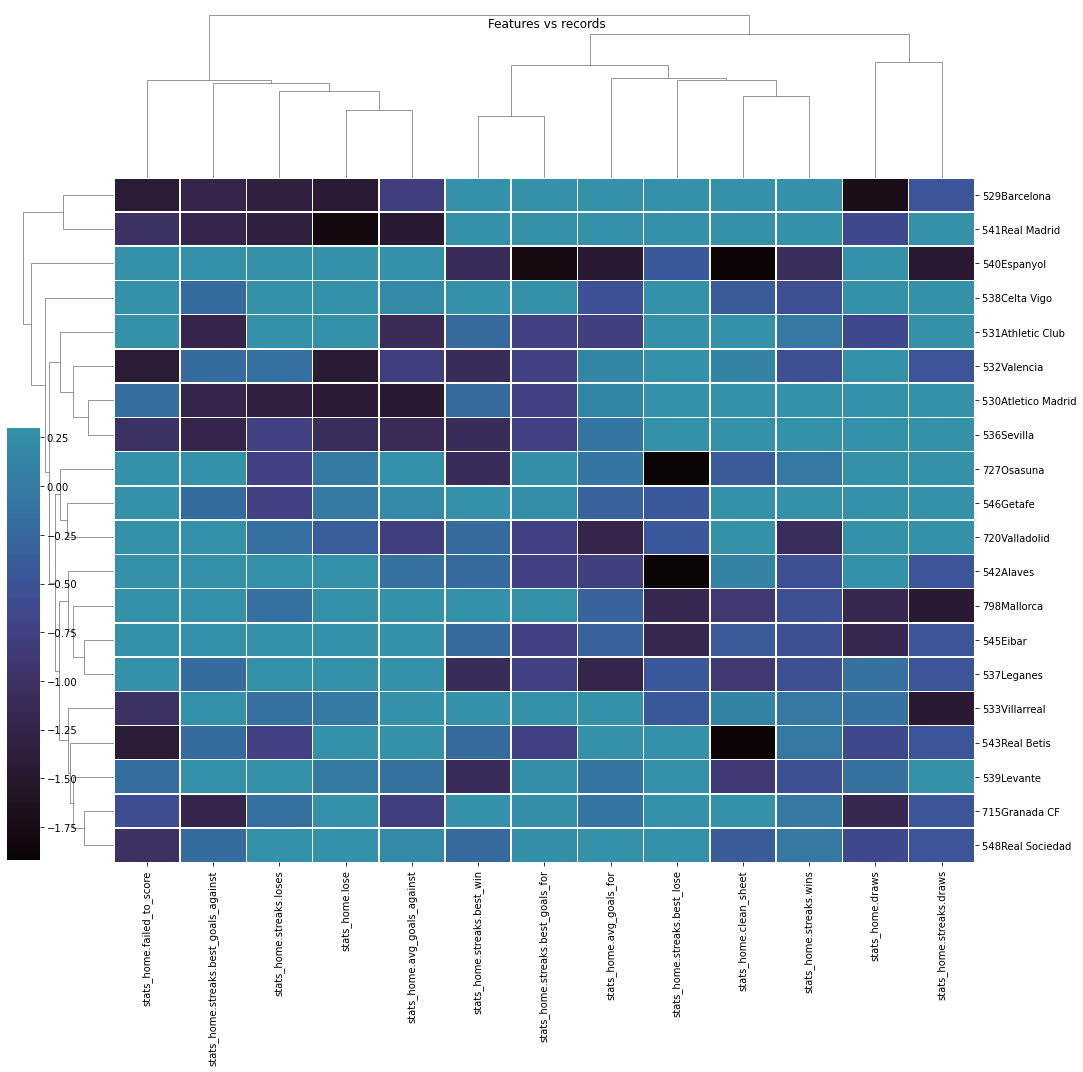

In [23]:
heatmap_data(all_data, all_lst, column_names, 'spearman', 'cluster')
_, relevant_features = get_correlation(all_data, all_lst, column_names, 'spearman', 'cluster', thresh=0.4)
print(relevant_features)
dendogram_vs_features(Z, all_data, all_names, column_names)

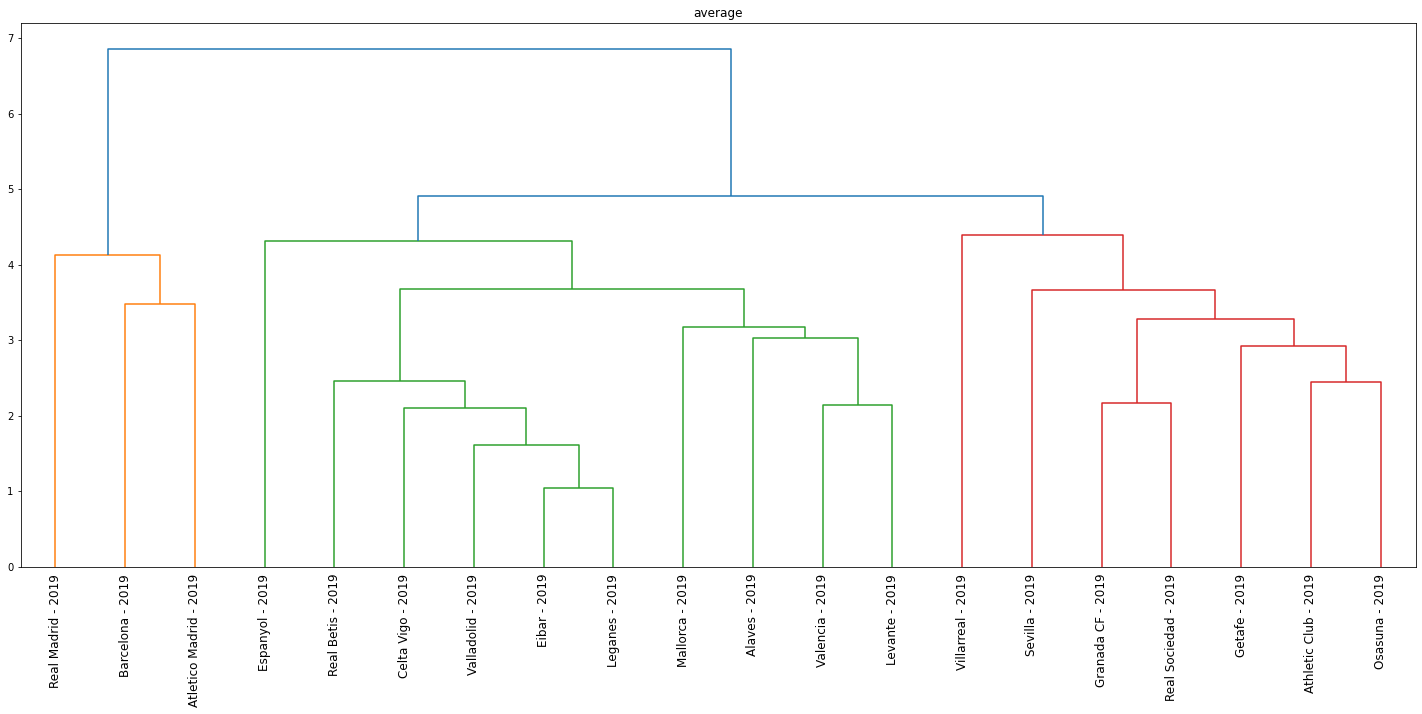

In [24]:
# Data initialization
data, column_names = ranking.concat_data(country, league, seasons, target_col, clean_type='away')
all_data, all_season, all_names, all_target = ranking.get_all_data(data, len(target_col))
# Use Agglomerative
all_data = preprocessing.StandardScaler().fit_transform(all_data)
dendo_label = label_team_season(all_names, all_season)
Z, coph_matrix, coph = HierarchicalClustering(all_data, dendo_label)

In [25]:
away_dct, _ = dct_clusters(Z, coph_matrix, dendo_label)

threshold = 4.904404861736376
0 5 5 5 4 7 5 5 5 7 5 5 4 4 5 7 4 4 5 4 
5 0 3 4 5 7 4 3 4 7 3 4 5 5 4 7 5 5 4 5 
5 3 0 4 5 7 4 3 4 7 2 4 5 5 4 7 5 5 4 5 
5 4 4 0 5 7 2 4 2 7 4 2 5 5 4 7 5 5 2 5 
4 5 5 5 0 7 5 5 5 7 5 5 3 4 5 7 3 2 5 3 
7 7 7 7 7 0 7 7 7 3 7 7 7 7 7 4 7 7 7 7 
5 4 4 2 5 7 0 4 1 7 4 2 5 5 4 7 5 5 2 5 
5 3 3 4 5 7 4 0 4 7 3 4 5 5 4 7 5 5 4 5 
5 4 4 2 5 7 1 4 0 7 4 2 5 5 4 7 5 5 2 5 
7 7 7 7 7 3 7 7 7 0 7 7 7 7 7 4 7 7 7 7 
5 3 2 4 5 7 4 3 4 7 0 4 5 5 4 7 5 5 4 5 
5 4 4 2 5 7 2 4 2 7 4 0 5 5 4 7 5 5 2 5 
4 5 5 5 3 7 5 5 5 7 5 5 0 4 5 7 3 3 5 2 
4 5 5 5 4 7 5 5 5 7 5 5 4 0 5 7 4 4 5 4 
5 4 4 4 5 7 4 4 4 7 4 4 5 5 0 7 5 5 4 5 
7 7 7 7 7 4 7 7 7 4 7 7 7 7 7 0 7 7 7 7 
4 5 5 5 3 7 5 5 5 7 5 5 3 4 5 7 0 3 5 3 
4 5 5 5 2 7 5 5 5 7 5 5 3 4 5 7 3 0 5 3 
5 4 4 2 5 7 2 4 2 7 4 2 5 5 4 7 5 5 0 5 
4 5 5 5 3 7 5 5 5 7 5 5 2 4 5 7 3 3 5 0 


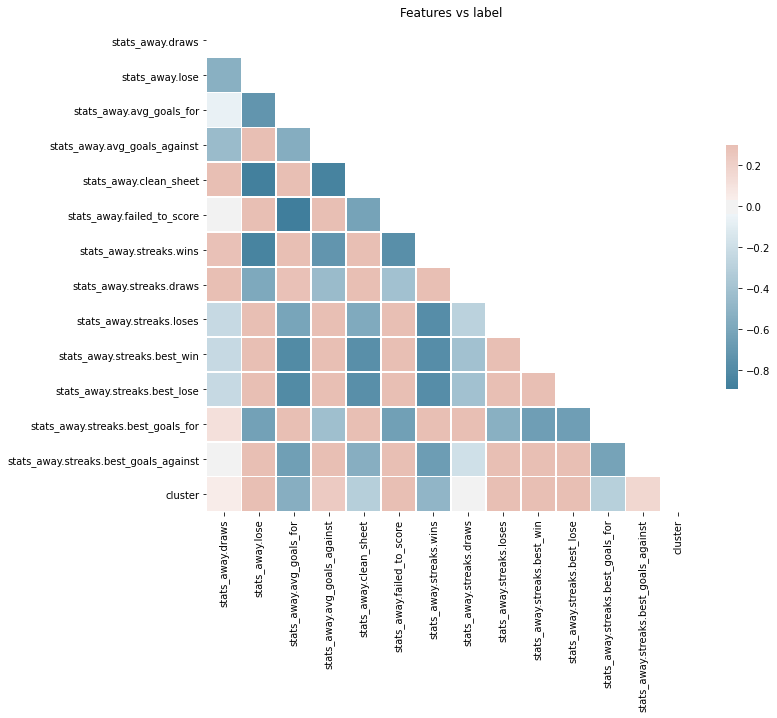

cluster                         1.000000
stats_away.streaks.loses        0.588514
stats_away.avg_goals_for        0.538401
stats_away.streaks.best_lose    0.496598
stats_away.streaks.best_win     0.496598
stats_away.streaks.wins         0.487495
stats_away.failed_to_score      0.462083
Name: cluster, dtype: float64


/anaconda3/envs/thesis/lib/python3.7/site-packages/seaborn/matrix.py:1201: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


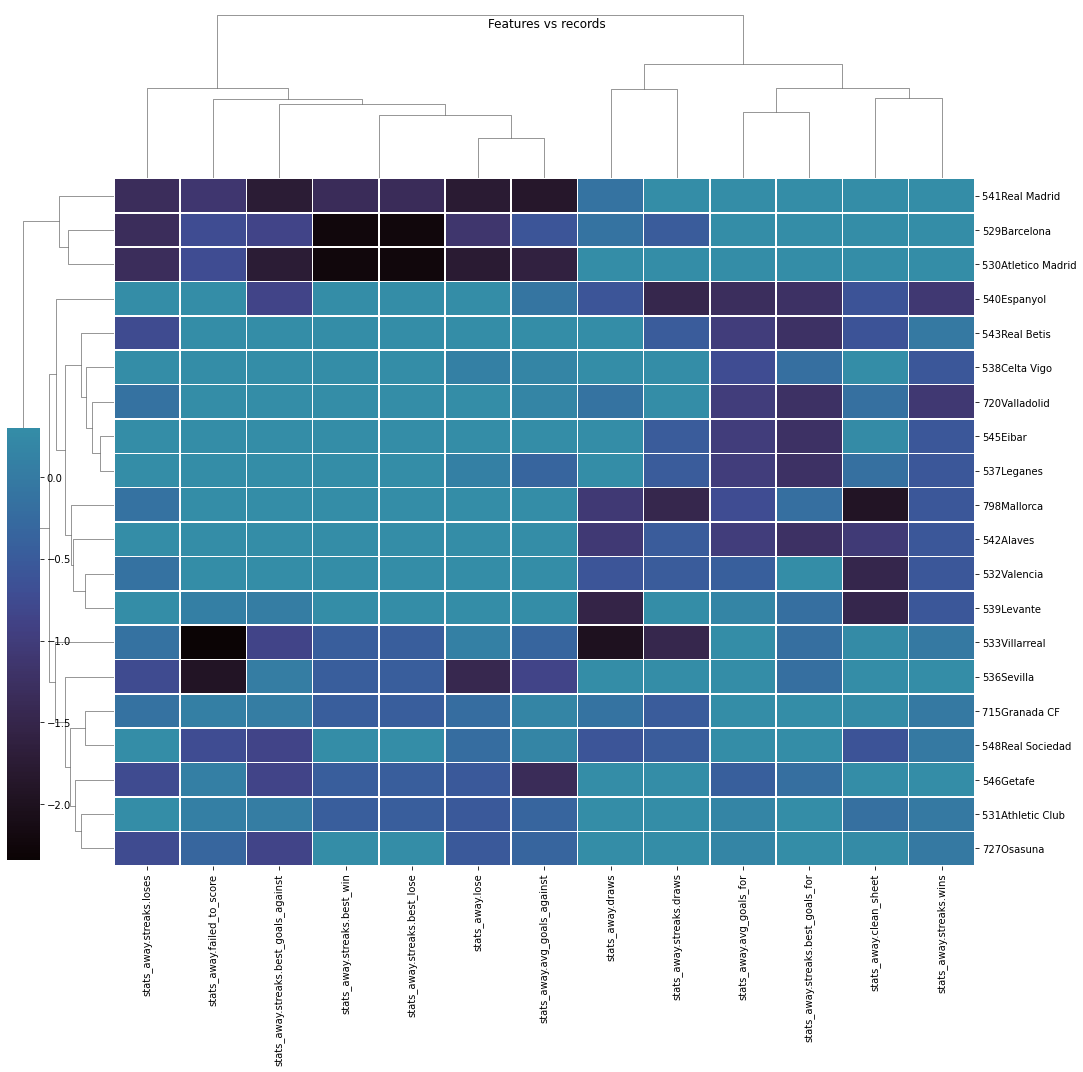

In [26]:
heatmap_data(all_data, all_lst, column_names, 'spearman', 'cluster')
_, relevant_features = get_correlation(all_data, all_lst, column_names, 'spearman', 'cluster', thresh=0.4)
print(relevant_features)
dendogram_vs_features(Z, all_data, all_names, column_names)

In [28]:
print(away_dct['533']['2019'].value)

2
